In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, power_transform, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import sklearn
from sklearn.impute import SimpleImputer
import phik
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.pipeline import Pipeline as impipe
from phik.binning import bin_data
import itertools
import mlflow
import optuna
from sklearn.metrics import (
    accuracy_score,
    make_scorer,
    PrecisionRecallDisplay,
    precision_recall_curve,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    balanced_accuracy_score,
    ConfusionMatrixDisplay,
    confusion_matrix,
    roc_curve
)

e:\projects\stroke\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mlflow.set_tracking_uri("http://84.201.180.128:8000/")
pd.options.display.max_columns = None
sklearn.set_config(transform_output='pandas')
pd.set_option('display.max_columns', None)

In [3]:
data=pd.read_csv(r"E:\projects\stroke\data\brain_stroke.csv")

data

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
4976,Male,41.0,0,0,No,Private,Rural,70.15,29.8,formerly smoked,0
4977,Male,40.0,0,0,Yes,Private,Urban,191.15,31.1,smokes,0
4978,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,31.8,smokes,0
4979,Male,40.0,0,0,Yes,Private,Rural,83.94,30.0,smokes,0


In [4]:
data.isnull().sum()

gender            0
age               0
hypertension      0
heart_disease     0
ever_married      0
work_type         0
residence_type    0
glucose_level     0
bmi               0
smoking_status    0
stroke            0
dtype: int64

In [5]:
cols = data.columns.to_list()
nuniques = [data[col].nunique() for col in cols]
dtypes = data.dtypes

pd.DataFrame({'dtype': dtypes, 'n uniques': nuniques})

,dtype,n uniques
gender,object,2
age,float64,104
hypertension,int64,2
heart_disease,int64,2
ever_married,object,2
work_type,object,4
residence_type,object,2
glucose_level,float64,3895
bmi,float64,342
smoking_status,object,4


In [6]:
eda_data = data.copy()

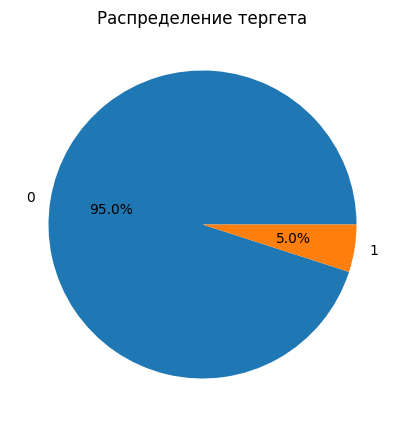

In [7]:
fig, axes = plt.subplots(figsize=(5, 5))
ax = plt.pie(eda_data['stroke'].value_counts(), labels=eda_data['stroke'].value_counts().index, autopct="%.1f%%",)
plt.title('Распределение тергета')
plt.show()

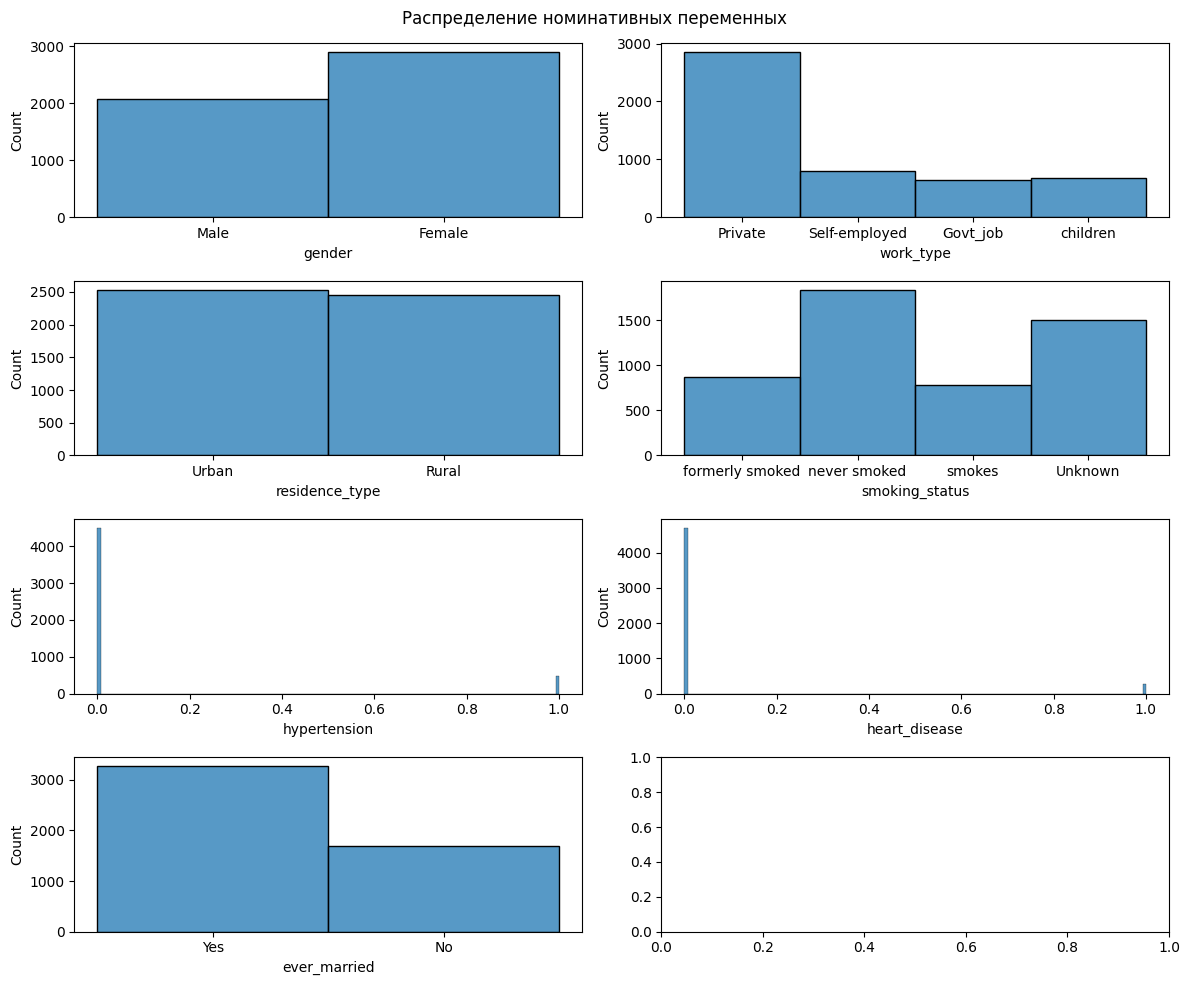

In [8]:
fig, axes = plt.subplots(4, 2, figsize=(12, 10))
plt.suptitle('Распределение номинативных переменных')

ax = sns.histplot(data=eda_data, x='gender', ax=axes[0][0])
ax = sns.histplot(data=eda_data, x='work_type', ax=axes[0][1])
ax = sns.histplot(data=eda_data, x='residence_type', ax=axes[1][0])
ax = sns.histplot(data=eda_data, x='smoking_status', ax=axes[1][1])
ax = sns.histplot(data=eda_data, x='hypertension', ax=axes[2][0])
ax = sns.histplot(data=eda_data, x='heart_disease', ax=axes[2][1])
ax = sns.histplot(data=eda_data, x='ever_married', ax=axes[3][0])

plt.tight_layout()
plt.show()

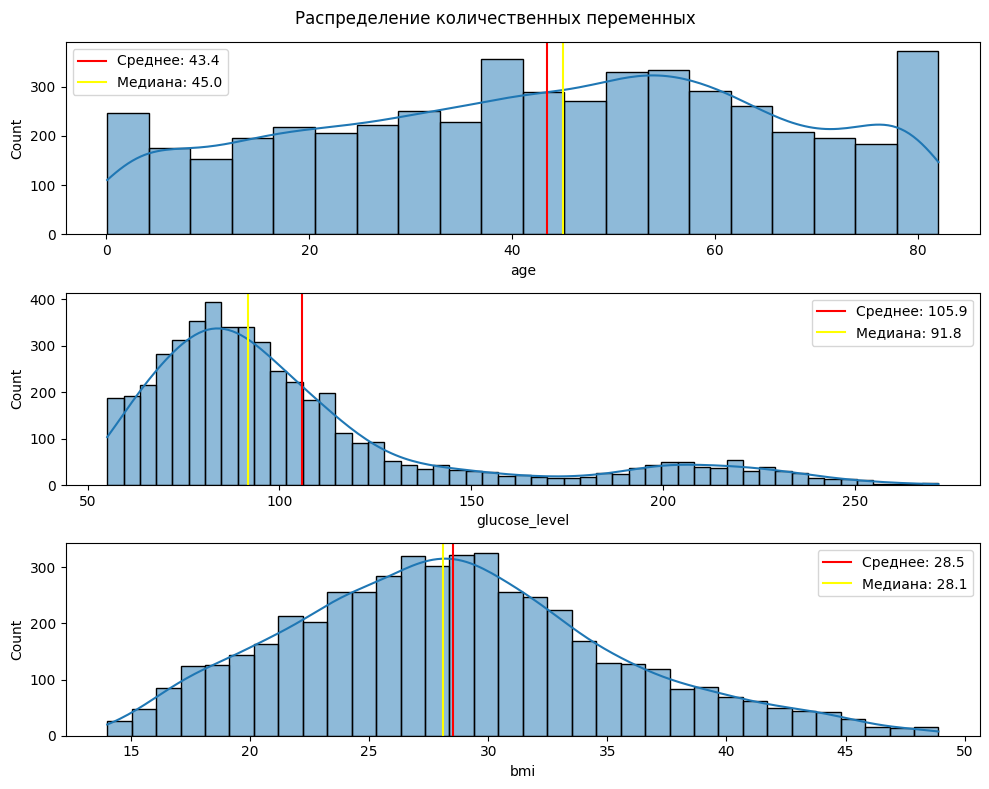

In [9]:
fig, axes = plt.subplots(3, figsize=(10, 8))
plt.suptitle('Распределение количественных переменных')

ax1 = sns.histplot(data=eda_data, x='age', kde=True, ax=axes[0])
ax1.axvline(x=eda_data["age"].mean(), color="red", label=f"Среднее: {np.round(eda_data['age'].mean(), 1)}")
ax1.axvline(x=eda_data["age"].median(), color="yellow", label=f"Медиана: {np.round(eda_data['age'].median(), 1)}")
ax1.legend()

ax2 = sns.histplot(data=eda_data, x='glucose_level', kde=True, ax=axes[1])
ax2.axvline(x=eda_data["glucose_level"].mean(), color="red", label=f"Среднее: {np.round(eda_data['glucose_level'].mean(), 1)}")
ax2.axvline(x=eda_data["glucose_level"].median(), color="yellow", label=f"Медиана: {np.round(eda_data['glucose_level'].median(), 1)}")
ax2.legend()

ax3 = sns.histplot(data=eda_data, x='bmi', kde=True, ax=axes[2])
ax3.axvline(x=eda_data["bmi"].mean(), color="red", label=f"Среднее: {np.round(eda_data['bmi'].mean(), 1)}")
ax3.axvline(x=eda_data["bmi"].median(), color="yellow", label=f"Медиана: {np.round(eda_data['bmi'].median(), 1)}")
ax3.legend()

plt.tight_layout()
plt.show()

In [10]:
num_data = eda_data[['age', 'glucose_level', 'bmi']].copy()

In [11]:
for col in num_data.columns:
    num_data[col] = PowerTransformer(method='yeo-johnson').fit_transform(num_data[[col]])

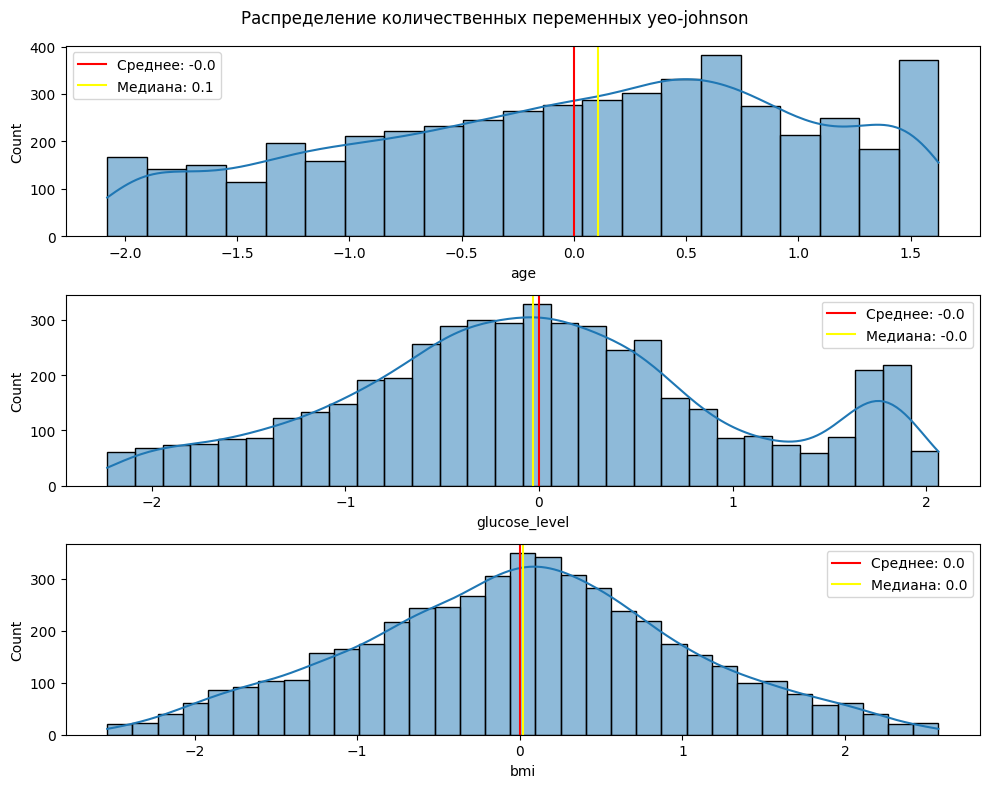

In [12]:
fig, axes = plt.subplots(3, figsize=(10, 8))
plt.suptitle('Распределение количественных переменных yeo-johnson')

ax1 = sns.histplot(data=num_data, x='age', kde=True, ax=axes[0])
ax1.axvline(x=num_data['age'].mean(), color="red", label=f"Среднее: {np.round(num_data['age'].mean(), 1)}")
ax1.axvline(x=num_data["age"].median(), color="yellow", label=f"Медиана: {np.round(num_data['age'].median(), 1)}")
ax1.legend()

ax2 = sns.histplot(data=num_data, x='glucose_level', kde=True, ax=axes[1])
ax2.axvline(x=num_data["glucose_level"].mean(), color="red", label=f"Среднее: {np.round(num_data['glucose_level'].mean(), 1)}")
ax2.axvline(x=num_data["glucose_level"].median(), color="yellow", label=f"Медиана: {np.round(num_data['glucose_level'].median(), 1)}")
ax2.legend()

ax3 = sns.histplot(data=num_data, x='bmi', kde=True, ax=axes[2])
ax3.axvline(x=num_data["bmi"].mean(), color="red", label=f"Среднее: {np.round(num_data['bmi'].mean(), 1)}")
ax3.axvline(x=num_data["bmi"].median(), color="yellow", label=f"Медиана: {np.round(num_data['bmi'].median(), 1)}")
ax3.legend()

plt.tight_layout()
plt.show()

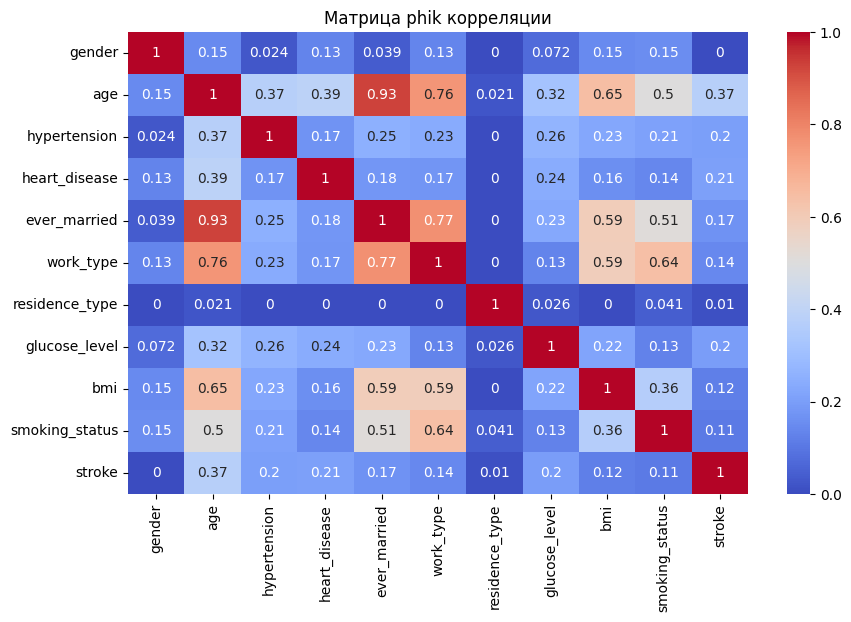

In [13]:
fig, axes = plt.subplots(figsize=(10, 6))
ax = sns.heatmap(eda_data.phik_matrix(interval_cols=['age', 'bmi', 'glucose_level']), cmap='coolwarm', annot=True)
ax.set_title('Матрица phik корреляции')
plt.show()

In [14]:
corr_data = eda_data[['age', 'glucose_level', 'bmi', 'smoking_status']].copy()

In [15]:
data_binned, binning_dict = bin_data(corr_data, cols=['age', 'glucose_level', 'bmi'], retbins=True)

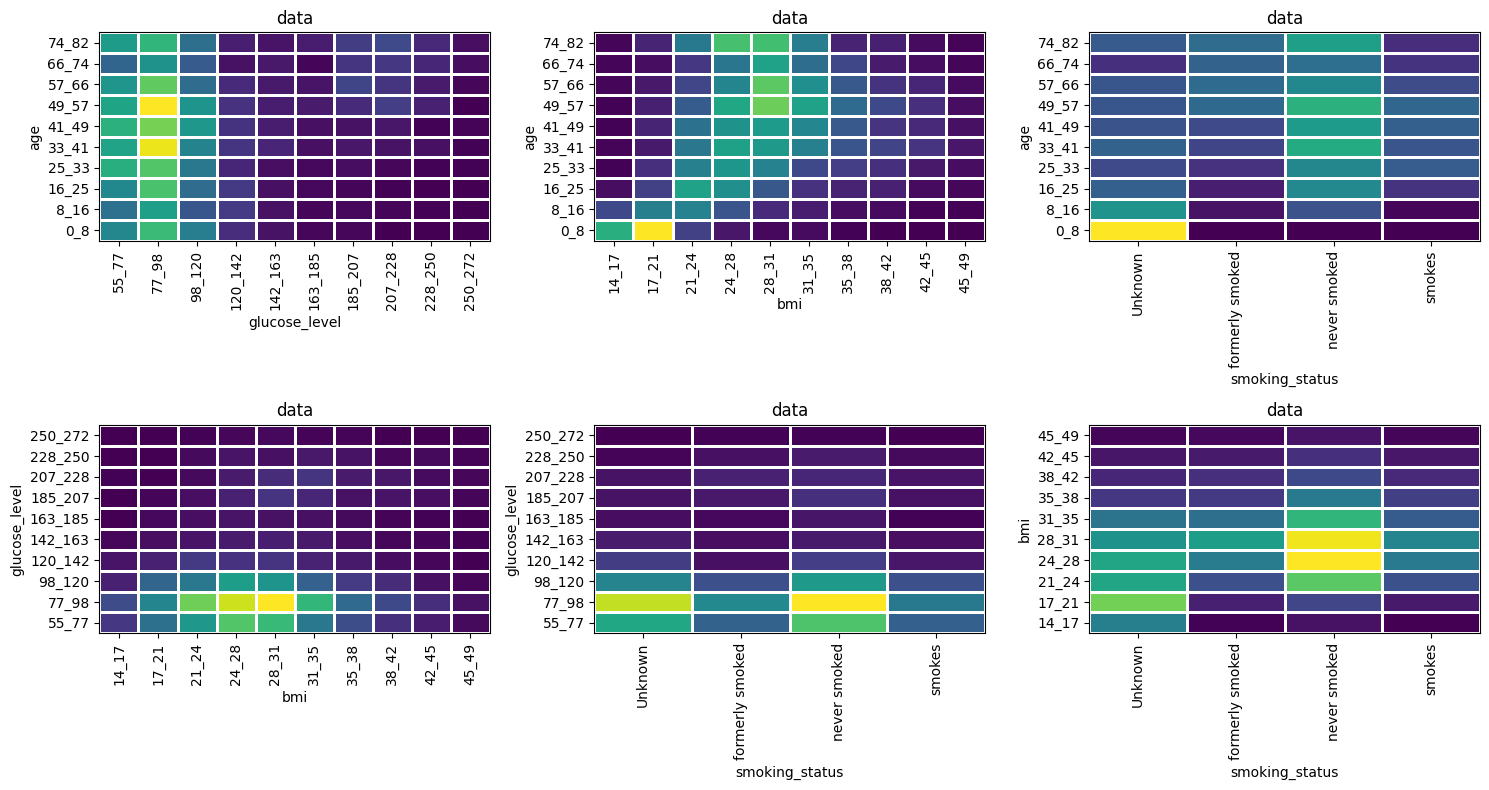

In [16]:
plt.rc('text', usetex=False)

n=0
for i in range(corr_data.shape[1]):
    n=n+i
    
ncols=3
nrows=int(np.ceil(n/ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(15,4*nrows))
ndecimals = 0

for i, comb in enumerate(itertools.combinations(data_binned.columns.values, 2)):
    
    c = int(i%ncols)
    r = int((i-c)/ncols )

    # get data
    c0, c1 = comb
    datahist = data_binned.groupby([c0,c1], observed=False)[c0].count().to_frame().unstack().fillna(0)
    datahist.columns = datahist.columns.droplevel()
    
    # plot data
    img = axes[r][c].pcolormesh(datahist.values, edgecolor='w', linewidth=1)
    
    # axis ticks and tick labels
    if c0 in binning_dict.keys():
        ylabels = ['{1:.{0}f}_{2:.{0}f}'.format(ndecimals, binning_dict[c0][i][0], binning_dict[c0][i][1])
                   for i in range(len(binning_dict[c0]))]
    else:
        ylabels = datahist.index

    if c1 in binning_dict.keys():        
        xlabels = ['{1:.{0}f}_{2:.{0}f}'.format(ndecimals, binning_dict[c1][i][0], binning_dict[c1][i][1])
                    for i in range(len(binning_dict[c1]))]
    else:
        xlabels = datahist.columns
    
    # axis labels
    axes[r][c].set_yticks(np.arange(len(ylabels)) + 0.5)
    axes[r][c].set_xticks(np.arange(len(xlabels)) + 0.5)
    axes[r][c].set_xticklabels(xlabels, rotation='vertical')
    axes[r][c].set_yticklabels(ylabels, rotation='horizontal')    
    axes[r][c].set_xlabel(datahist.columns.name)
    axes[r][c].set_ylabel(datahist.index.name)    
    axes[r][c].set_title('data')
    
plt.tight_layout()

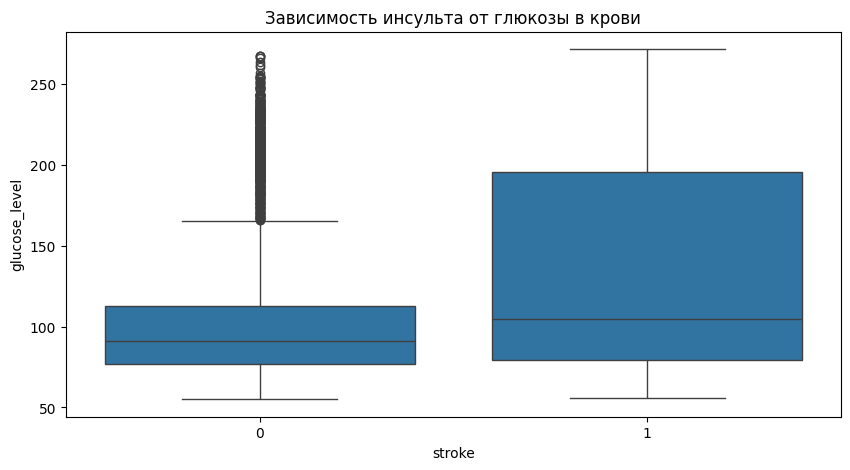

In [17]:
fig, axes = plt.subplots(figsize=(10, 5))
ax = sns.boxplot(data=eda_data, x='stroke', y='glucose_level')
ax.set_title('Зависимость инсульта от глюкозы в крови')
plt.show()

In [18]:
gstroke = eda_data.groupby(['gender', 'stroke']).agg(strokeCounter=('stroke', 'count')).reset_index()

gstroke

,gender,stroke,strokeCounter
0,Female,0,2767
1,Female,1,140
2,Male,0,1966
3,Male,1,108


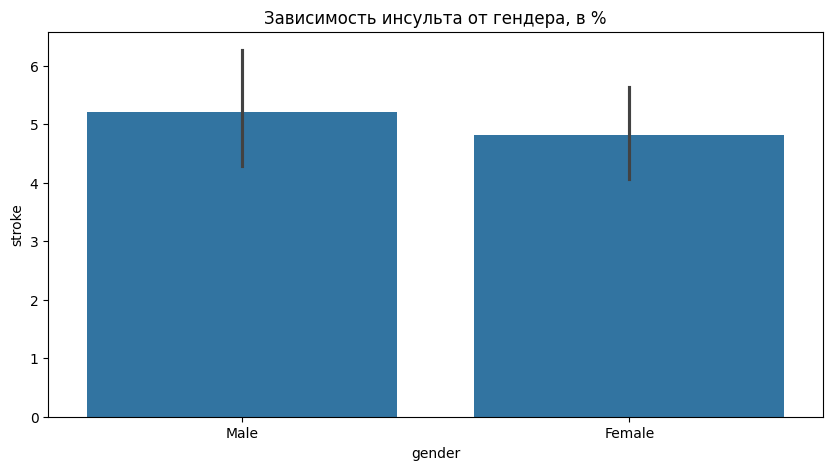

In [19]:
fig, axes = plt.subplots(figsize=(10, 5))
ax = sns.barplot(data=eda_data, x='gender', y='stroke', estimator=lambda x: sum(x) / len(x) * 100)
ax.set_title('Зависимость инсульта от гендера, в %')
plt.show()

In [20]:
eda_data['age_binned'] = pd.cut(eda_data['age'], bins=[0, 20, 35, 50, 100], labels=['До 18 лет', 'от 20 до 35 лет', 'от 35 до 50 лет', 'от 50 лет'])

In [21]:
astroke = eda_data.groupby(['age_binned', 'stroke',], observed=True).agg(strokeCounter=('stroke', 'count')).reset_index()

astroke

,age_binned,stroke,strokeCounter
0,До 18 лет,0,986
1,До 18 лет,1,2
2,от 20 до 35 лет,0,852
3,от 20 до 35 лет,1,1
4,от 35 до 50 лет,0,1028
5,от 35 до 50 лет,1,19
6,от 50 лет,0,1867
7,от 50 лет,1,226


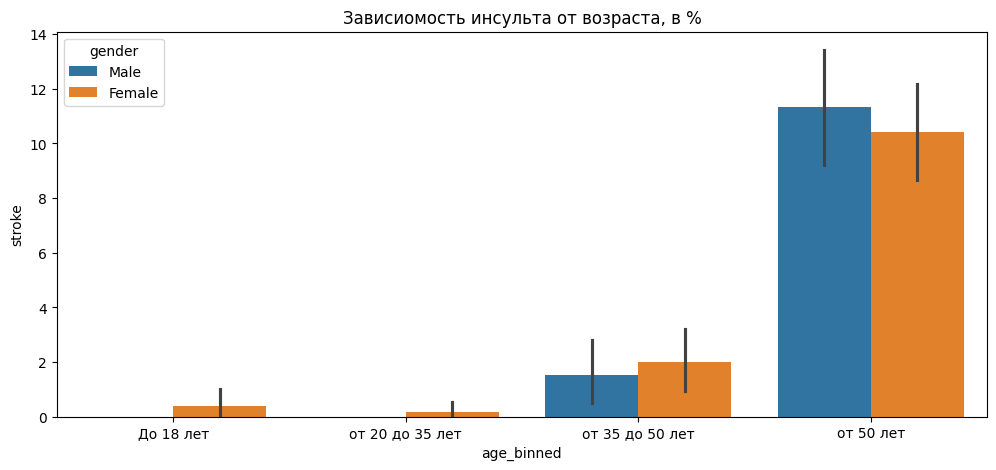

In [22]:
fig, axes = plt.subplots(figsize=(12, 5))
ax = sns.barplot(data=eda_data, x='age_binned', y='stroke', hue='gender', estimator=lambda x: sum(x) / len(x) * 100)
ax.set_title('Зависиомость инсульта от возраста, в %')
plt.show()

In [23]:
eda_data['bmi_binned'] = pd.cut(eda_data['bmi'], bins=[0, 20, 25, 30, 35, 50], labels=['имт до 20', 'имт от 20 до 25', 'имт от 25 до 30', 'имт от 30 до 35', 'имт от 35 до 50'])

In [24]:
wstroke = eda_data.groupby(['bmi_binned', 'stroke'], observed=True).agg(strokeCounter=('stroke', 'count')).reset_index()

wstroke

,bmi_binned,stroke,strokeCounter
0,имт до 20,0,524
1,имт до 20,1,4
2,имт от 20 до 25,0,1030
3,имт от 20 до 25,1,35
4,имт от 25 до 30,0,1399
5,имт от 25 до 30,1,101
6,имт от 30 до 35,0,1004
7,имт от 30 до 35,1,67
8,имт от 35 до 50,0,776
9,имт от 35 до 50,1,41


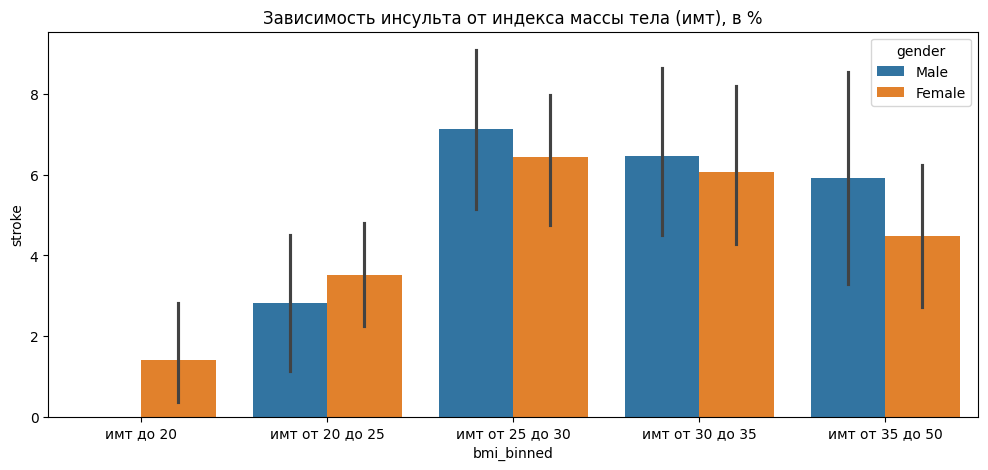

In [25]:
fig, axes = plt.subplots(figsize=(12, 5))
ax = sns.barplot(data=eda_data, x='bmi_binned', y='stroke', hue='gender', estimator= lambda x: sum(x) / len(x) * 100)
ax.set_title('Зависимость инсульта от индекса массы тела (имт), в %')
plt.show()

In [26]:
sstroke = eda_data.groupby(['smoking_status', 'stroke'], observed=True).agg(strokeCounter=('stroke', 'count')).reset_index()

sstroke

,smoking_status,stroke,strokeCounter
0,Unknown,0,1453
1,Unknown,1,47
2,formerly smoked,0,797
3,formerly smoked,1,70
4,never smoked,0,1749
5,never smoked,1,89
6,smokes,0,734
7,smokes,1,42


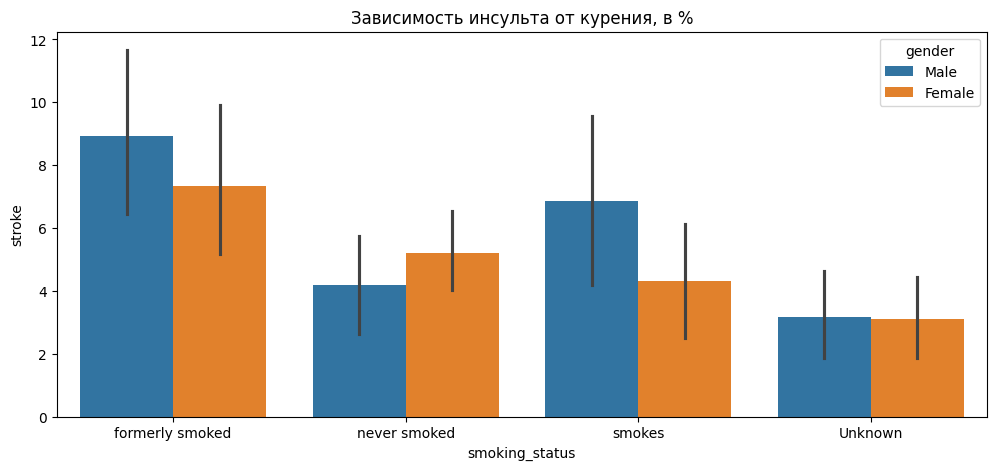

In [27]:
fig, axes = plt.subplots(figsize=(12, 5))
ax = sns.barplot(data=eda_data, x='smoking_status', y='stroke', hue='gender', estimator=lambda x: sum(x) / len(x) * 100)
ax.set_title('Зависимость инсульта от курения, в %')
plt.show()

In [28]:
ahdstroke = eda_data.groupby(['age_binned', 'stroke', 'heart_disease'], observed=False).agg(strokeCounter=('stroke', 'count')).reset_index()

ahdstroke

,age_binned,stroke,heart_disease,strokeCounter
0,До 18 лет,0,0,985
1,До 18 лет,0,1,1
2,До 18 лет,1,0,2
3,До 18 лет,1,1,0
4,от 20 до 35 лет,0,0,850
5,от 20 до 35 лет,0,1,2
6,от 20 до 35 лет,1,0,1
7,от 20 до 35 лет,1,1,0
8,от 35 до 50 лет,0,0,1012
9,от 35 до 50 лет,0,1,16


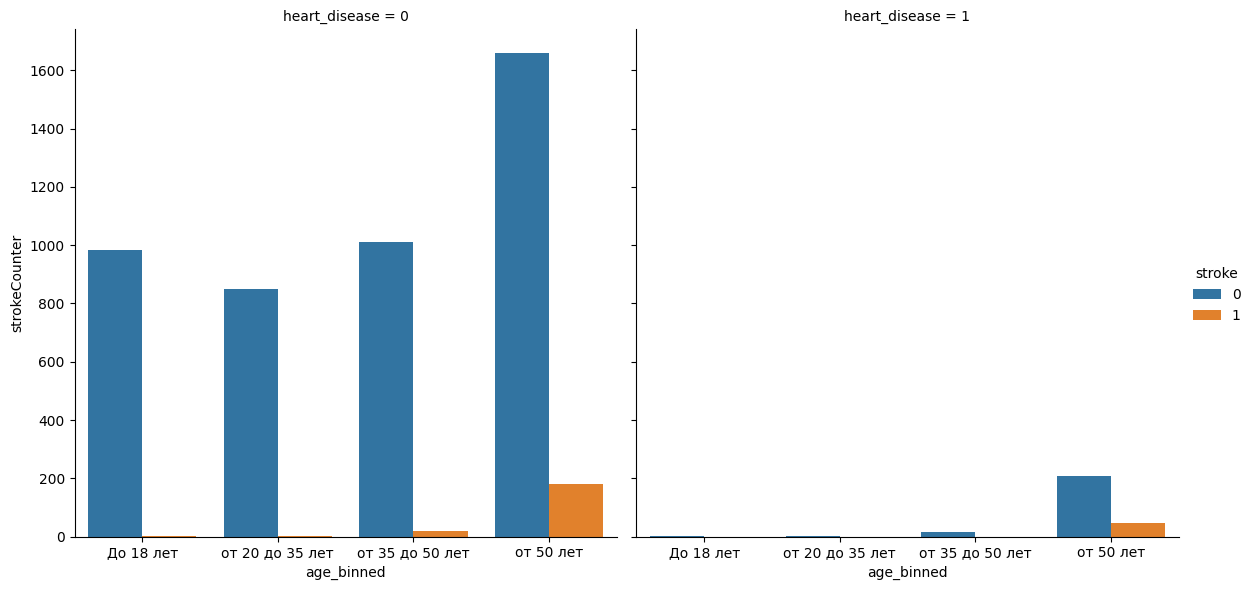

In [29]:
sns.catplot(x=ahdstroke.age_binned, y=ahdstroke.strokeCounter, hue=ahdstroke.stroke, col=ahdstroke.heart_disease, kind='bar', height=6)
plt.show()

In [30]:
ahtstroke = eda_data.groupby(['age_binned', 'stroke', 'hypertension'], observed=False).agg(strokeCounter=('stroke', 'count')).reset_index()

ahtstroke

,age_binned,stroke,hypertension,strokeCounter
0,До 18 лет,0,0,985
1,До 18 лет,0,1,1
2,До 18 лет,1,0,2
3,До 18 лет,1,1,0
4,от 20 до 35 лет,0,0,836
5,от 20 до 35 лет,0,1,16
6,от 20 до 35 лет,1,0,1
7,от 20 до 35 лет,1,1,0
8,от 35 до 50 лет,0,0,961
9,от 35 до 50 лет,0,1,67


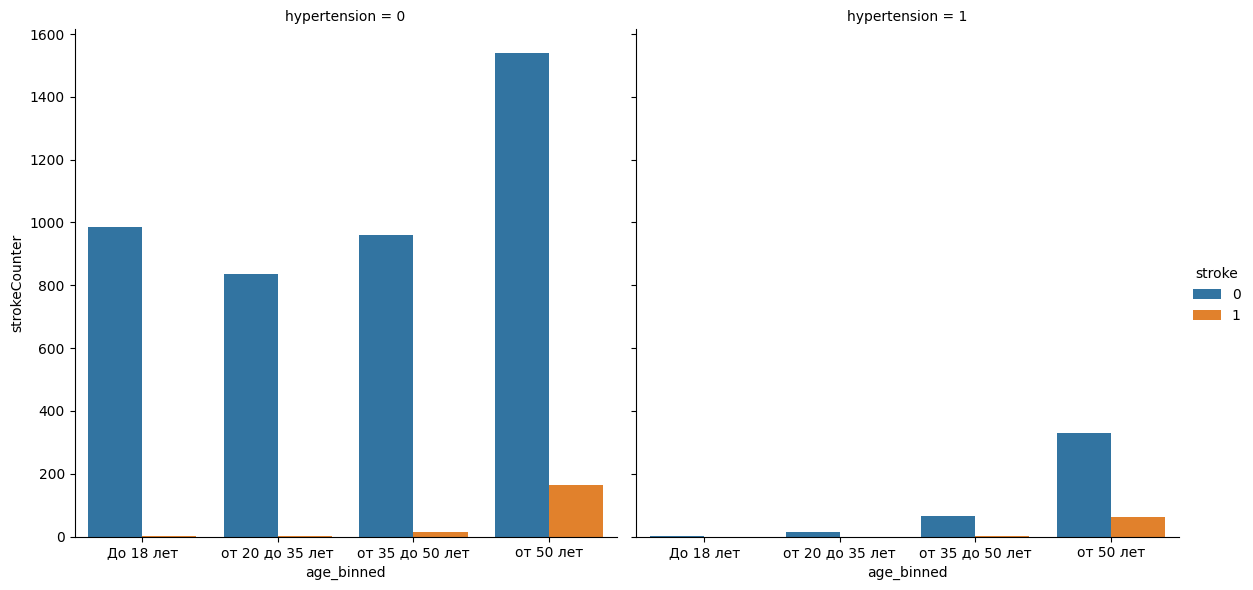

In [31]:
sns.catplot(x=ahtstroke.age_binned, y=ahtstroke.strokeCounter, hue=ahtstroke.stroke, col=ahtstroke.hypertension, kind='bar', height=6)
plt.show()

In [32]:
data['stroke'] = 1 - data['stroke']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('stroke', axis=1), data['stroke'], stratify=data['stroke'], test_size=0.2, random_state=42)

In [34]:
cat_cols = X_train.select_dtypes(include='object').columns.to_list()
num_cols = X_train.select_dtypes(exclude='object').columns.to_list()

In [35]:
cat_pipe = Pipeline([
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore')),
])

In [36]:
num_pipe = Pipeline([
    ('pt', PowerTransformer(method='yeo-johnson'))
])

In [37]:
transformer = ColumnTransformer([
    ('num_pipe', num_pipe, num_cols),
    ('cat_pipe', cat_pipe, cat_cols),
])

In [38]:
xgboost_pipe = impipe([
    ('transformer', transformer),
    ('smote', SMOTE(random_state=42)),
    ('model', XGBClassifier())
])

In [39]:
def objective_xgb(trial):
    params = {
                'model__eta': trial.suggest_float('model__eta', 0, 1),
                'model__max_depth': trial.suggest_int('model__max_depth', 6, 100),
                'model__max_leaves': trial.suggest_int('model__max_leaves', 0, 100000),
                'model__gamma': trial.suggest_float('model__gamma', 0, 1),
                'model__min_child_weight': trial.suggest_float('model__min_child_weight', 0, 10),
                'model__lambda': trial.suggest_float('model__lambda', 0, 5),
                'model__alpha': trial.suggest_float('model__alpha', 0, 5),
                'model__n_estimators': trial.suggest_categorical("model__n_estimators", [1000])
            }

    xgboost_pipe.set_params(**params)
    
    score = make_scorer(f1_score, pos_label=0)

    return cross_val_score(xgboost_pipe, X_train, y_train, cv=5, scoring=score).mean()
    

In [40]:
study = optuna.create_study(direction='maximize')

[I 2025-06-14 01:19:25,925] A new study created in memory with name: no-name-e6f1a07b-64cb-492e-b2cd-39c6aa3f7472


In [41]:
study.optimize(objective_xgb, n_trials=100)

[I 2025-06-14 01:19:32,697] Trial 0 finished with value: 0.11670890219991725 and parameters: {'model__eta': 0.011849422938349674, 'model__max_depth': 67, 'model__max_leaves': 29726, 'model__gamma': 0.758431403026968, 'model__min_child_weight': 9.7710516404943, 'model__lambda': 1.9823402551024278, 'model__alpha': 0.33573039648902236, 'model__n_estimators': 1000}. Best is trial 0 with value: 0.11670890219991725.
[I 2025-06-14 01:19:34,656] Trial 1 finished with value: 0.13466598770597374 and parameters: {'model__eta': 0.10937072754022104, 'model__max_depth': 75, 'model__max_leaves': 75957, 'model__gamma': 0.1366477424797986, 'model__min_child_weight': 6.06620091287126, 'model__lambda': 1.380210148664807, 'model__alpha': 2.26886924061011, 'model__n_estimators': 1000}. Best is trial 1 with value: 0.13466598770597374.
[I 2025-06-14 01:19:36,008] Trial 2 finished with value: 0.15603092406029986 and parameters: {'model__eta': 0.9305491952291477, 'model__max_depth': 99, 'model__max_leaves': 48

In [42]:
xgboost_best = xgboost_pipe.set_params(**study.best_params)

In [43]:
xgboost_best.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('pt',
                                                                   PowerTransformer())]),
                                                  ['age', 'hypertension',
                                                   'heart_disease',
                                                   'glucose_level', 'bmi']),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['gender', 'ever_married',
                                                   'work_type',
                                                   'residence_type',
                                                   'smoking_status'])...
                               feature_weights=None, gamma=0.49631018668497096,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               lambda=2.881049098132826, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=14, max_leaves=12033,
                               min_child_weight=3.1163583645084816, missing=nan,
                               monotone_constraints=None, multi_strategy=None, ...))])

In [44]:
class FixDataType(BaseEstimator, TransformerMixin):
    def __init__(self, target_cols):
        self.target_cols = target_cols

    def fit(self, X, y=None):
        self.feature_names = X.columns
        return self
    
    def transform(self, X):
        for col in self.target_cols:
            X[col] = X[col].round().astype('int')

        return X
    
    def get_feature_names_out(self, input_features=None):
        return self.feature_names

In [45]:
cat_pipe2 = Pipeline([
    ('encoder', OrdinalEncoder())
])

In [46]:
transformer2 = ColumnTransformer([
    ('num_pipe', num_pipe, num_cols),
    ("cat_pipe", cat_pipe2, cat_cols)
],)

In [47]:
catboost_pipe = impipe([
    ("transformer", transformer2),
    ("smote", SMOTE(random_state=42)),
    ("fixer", FixDataType(['cat_pipe__' + x for x in cat_cols])),
    ("model", CatBoostClassifier(cat_features=["cat_pipe__" + x for x in cat_cols]))
])

In [48]:
catboost_pipe.fit(X_train, y_train)

Learning rate set to 0.024454
0:	learn: 0.6783387	total: 174ms	remaining: 2m 53s
1:	learn: 0.6655161	total: 198ms	remaining: 1m 38s
2:	learn: 0.6543690	total: 226ms	remaining: 1m 15s
3:	learn: 0.6430333	total: 246ms	remaining: 1m 1s
4:	learn: 0.6318717	total: 269ms	remaining: 53.5s
5:	learn: 0.6205350	total: 292ms	remaining: 48.3s
6:	learn: 0.6065457	total: 312ms	remaining: 44.2s
7:	learn: 0.5957091	total: 347ms	remaining: 43s
8:	learn: 0.5868457	total: 379ms	remaining: 41.7s
9:	learn: 0.5780064	total: 402ms	remaining: 39.8s
10:	learn: 0.5695903	total: 425ms	remaining: 38.2s
11:	learn: 0.5627278	total: 461ms	remaining: 38s
12:	learn: 0.5562310	total: 483ms	remaining: 36.6s
13:	learn: 0.5479579	total: 504ms	remaining: 35.5s
14:	learn: 0.5414892	total: 526ms	remaining: 34.5s
15:	learn: 0.5355951	total: 549ms	remaining: 33.7s
16:	learn: 0.5297473	total: 571ms	remaining: 33s
17:	learn: 0.5237573	total: 593ms	remaining: 32.4s
18:	learn: 0.5184409	total: 617ms	remaining: 31.8s
19:	learn: 0.5

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('pt',
                                                                   PowerTransformer())]),
                                                  ['age', 'hypertension',
                                                   'heart_disease',
                                                   'glucose_level', 'bmi']),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['gender', 'ever_married',
                                                   'work_type',
                                                   'residence_type',
                                                   'smoking_status'])])),
                ('smote', SMOTE(random_state=42)),
                ('fixer',
                 FixDataType(target_cols=['cat_pipe__gender',
                                          'cat_pipe__ever_married',
                                          'cat_pipe__work_type',
                                          'cat_pipe__residence_type',
                                          'cat_pipe__smoking_status'])),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x0000024C8746C590>)])

In [49]:
def report_metrics(mlflow, y_test, y_pred, y_proba, sufix):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=0)
    recall = recall_score(y_test, y_pred, pos_label=0)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    
    print(f"Accuracy_{sufix}: {accuracy}")
    print(f"Precision_{sufix}: {precision}")
    print(f"Recall_{sufix}: {recall}")
    print(f"F1 Score_{sufix}: {f1}")
    print(f"ROC AUC_{sufix}: {roc_auc}")
    print(f"Confusion Matrix_{sufix}:\n", cm)
    print(f"Balanced Accuracy_{sufix}: {balanced_accuracy}")

    mlflow.log_metric(f"accuracy_{sufix}", accuracy)
    mlflow.log_metric(f"precision_{sufix}", precision)
    mlflow.log_metric(f"recall_{sufix}", recall)
    mlflow.log_metric(f"f1_score_{sufix}", f1)
    mlflow.log_metric(f"roc_auc_{sufix}", roc_auc)
    mlflow.log_metric(f"balanced_accuracy_{sufix}", balanced_accuracy)
    mlflow.log_text(f"Confusion Matrix:\n{cm}", f"confusion_matrix_{sufix}.txt")

    fpr, tpr, threshold = roc_curve(y_test, y_proba)
    plt.figure(figsize=(30, 20))
    plt.plot(fpr, tpr, label=f"roc_curve_{sufix} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    mlflow.log_figure(plt.gcf(), f"roc_curve_{sufix}.png")
    plt.close()

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    mlflow.log_figure(plt.gcf(), f"confusion_matrix_{sufix}.png")
    plt.close()


In [50]:
def mlflow_run(best_pipeline, best_params, X_test, y_test):
    mlflow.log_params(best_params)

    y_pred = best_pipeline.predict(X_test)
    y_proba = best_pipeline.predict_proba(X_test)[:, 1]

    report_metrics(mlflow, y_test, y_pred, y_proba, 'ml')

    mlflow.sklearn.log_model(best_pipeline, "model_pipeline")


    try:
        importances = best_pipeline.feature_importances_
        feature_names = X_test.columns.to_list()
    except:
        importances = best_pipeline.named_steps['model'].feature_importances_
        feature_names = best_pipeline.named_steps['transformer'].get_feature_names_out()


    feat_imp_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values(by='importance', ascending=False)

    feat_imp_df = feat_imp_df[feat_imp_df['importance'] > 0].head(40)
    total_importance = feat_imp_df['importance'].sum()
    feat_imp_df['importance_fraction'] = feat_imp_df['importance'] / total_importance
    
    fig, ax = plt.subplots(figsize=(25, 25))
    bars = ax.barh(feat_imp_df['feature'], feat_imp_df['importance_fraction'], color='skyblue')
    ax.invert_yaxis()
    
    ax.set_title("Feature Importances from XGBoost")
    ax.set_xlabel("Importance (%)")
    ax.set_ylabel("Features")
    ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
    
    for bar in bars:
        width = bar.get_width()
        label_text = f"{width:.1%}"
        ax.text(
            width + 0.01,
            bar.get_y() + bar.get_height() / 2,
            label_text,
            va='center'
        )
    
    mlflow.log_figure(plt.gcf(), "feature_importances.png")

    feat_imp_df.to_csv("feature_importances.csv", index=False)
    mlflow.log_artifact("feature_importances.csv")
    
    plt.close()
    

    print("\nRun finished. All results have been logged to MLflow.")

In [51]:
mlflow.set_experiment("BrainStroke")

2025/06/14 01:22:31 INFO mlflow.tracking.fluent: Experiment with name 'BrainStroke' does not exist. Creating a new experiment.


<Experiment: artifact_location='s3://mlflow-buck/artifacts/3', creation_time=1749853351619, experiment_id='3', last_update_time=1749853351619, lifecycle_stage='active', name='BrainStroke', tags={}>

In [52]:
name = 'catboost'

with mlflow.start_run(run_name=f"{name}_experiment"):
    mlflow_run(catboost_pipe, {}, X_test, y_test)

Accuracy_ml: 0.9147442326980942
Precision_ml: 0.21311475409836064
Recall_ml: 0.26
F1 Score_ml: 0.9187195964703208
ROC AUC_ml: 0.7926504751847941
Confusion Matrix_ml:
 [[ 13  37]
 [ 48 899]]
Balanced Accuracy_ml: 0.6046568109820486


2025/06/14 01:22:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/14 01:22:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run finished. All results have been logged to MLflow.
🏃 View run catboost_experiment at: http://84.201.180.128:8000/#/experiments/3/runs/ba4da6a72ba84027b7fec5f221f54806
🧪 View experiment at: http://84.201.180.128:8000/#/experiments/3


In [53]:
name = 'xgboost'

with mlflow.start_run(run_name=f"{name}_experiment"):
    mlflow_run(xgboost_best, xgboost_best.get_params(), X_test, y_test)

Accuracy_ml: 0.9017051153460381
Precision_ml: 0.125
Recall_ml: 0.16
F1 Score_ml: 0.9073747745663268
ROC AUC_ml: 0.812481520591341
Confusion Matrix_ml:
 [[  8  42]
 [ 56 891]]
Balanced Accuracy_ml: 0.5504329461457234


2025/06/14 01:22:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/14 01:22:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run finished. All results have been logged to MLflow.
🏃 View run xgboost_experiment at: http://84.201.180.128:8000/#/experiments/3/runs/a2ade67a76614ee3b72911480add9eca
🧪 View experiment at: http://84.201.180.128:8000/#/experiments/3
